#Challenge Telecom X 2
##Objetivo
Criação de um modelo de previsão de evasão (churn), identificar clientes que evadirão, com o obejetivo de evitar a perda do mesmo

##Chamada de bibliotecas

In [264]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay

##Carregamento das Data Base e Remoção de dados descenescessarios


In [245]:
df = pd.read_csv('TelecomX_Data_processed.csv')
display(df.head())

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Contas_Diarias
0,0002-ORFBO,0.0,Female,0.0,1.0,1.0,9,1.0,0.0,DSL,...,0.0,1.0,1.0,0.0,One year,1.0,Mailed check,65.6,593.30,2.186667
1,0003-MKNFE,0.0,Male,0.0,0.0,0.0,9,1.0,1.0,DSL,...,0.0,0.0,0.0,1.0,Month-to-month,0.0,Mailed check,59.9,542.40,1.996667
2,0004-TLHLJ,1.0,Male,0.0,0.0,0.0,4,1.0,0.0,Fiber optic,...,1.0,0.0,0.0,0.0,Month-to-month,1.0,Electronic check,73.9,280.85,2.463333
3,0011-IGKFF,1.0,Male,1.0,1.0,0.0,13,1.0,0.0,Fiber optic,...,1.0,0.0,1.0,1.0,Month-to-month,1.0,Electronic check,98.0,1237.85,3.266667
4,0013-EXCHZ,1.0,Female,1.0,1.0,0.0,3,1.0,0.0,Fiber optic,...,0.0,1.0,1.0,0.0,Month-to-month,1.0,Mailed check,83.9,267.40,2.796667


In [246]:
#Procura por colunas que possuem ceclulas vazias ou iguais a NaN
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


In [247]:
df = df.drop(columns=['customerID'], errors='ignore')

##Preparação de dados


###Utilização da tecnica one-hor encoding
E nescessario para podermos transformar variaveis categoricas em formato nuemrico

In [248]:
# Apply one-hot encoding to specified columns
df_encoded = pd.get_dummies(df, columns=['gender','InternetService', 'Contract', 'PaymentMethod'], drop_first=True)

for col in ['gender_Male','gender_Female','InternetService_Fiber optic', 'InternetService_No',
            'Contract_One year', 'Contract_Two year',
            'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check',
            'PaymentMethod_Mailed check']:
    if col in df_encoded.columns:
        df_encoded[col] = df_encoded[col].astype(int)


display(df_encoded.head())

,Churn,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,TotalCharges,Contas_Diarias,gender_Male,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.0,0.0,1.0,1.0,9,1.0,0.0,0.0,1.0,0.0,...,593.30,2.186667,0,0,0,1,0,0,0,1
1,0.0,0.0,0.0,0.0,9,1.0,1.0,0.0,0.0,0.0,...,542.40,1.996667,1,0,0,0,0,0,0,1
2,1.0,0.0,0.0,0.0,4,1.0,0.0,0.0,0.0,1.0,...,280.85,2.463333,1,1,0,0,0,0,1,0
3,1.0,1.0,1.0,0.0,13,1.0,0.0,0.0,1.0,1.0,...,1237.85,3.266667,1,1,0,0,0,0,1,0
4,1.0,1.0,1.0,0.0,3,1.0,0.0,0.0,0.0,0.0,...,267.40,2.796667,0,1,0,0,0,0,0,1


Verificação da Proporção de Evasão

In [249]:
display(df_encoded['Churn'].value_counts())
display(df_encoded['Churn'].value_counts(normalize=True))

,count
Churn,
0.0,5398
1.0,1869


,proportion
Churn,
0.0,0.74281
1.0,0.25719


In [250]:
df_encoded.describe()

,Churn,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,TotalCharges,Contas_Diarias,gender_Male,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
count,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,...,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000
mean,0.257190,0.162653,0.484106,0.300124,32.346498,0.902711,0.324481,0.068391,0.127013,0.125224,...,2277.182035,2.157337,0.505711,0.440072,0.217559,0.209027,0.239851,0.215770,0.336452,0.229118
std,0.437115,0.369074,0.499782,0.458343,24.571773,0.296371,0.643295,0.706329,0.738968,0.738062,...,2268.648587,1.004319,0.500002,0.496430,0.412614,0.406642,0.427022,0.411384,0.472528,0.420294
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,0.000000,0.608333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,396.200000,1.180833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,29.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1389.200000,2.343333,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,3778.525000,2.995833,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,8684.800000,3.958333,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


##Normalização dos dados

In [251]:
from sklearn.preprocessing import StandardScaler

# Identify numerical columns (excluding the target variable 'Churn' and one-hot encoded columns)
numerical_cols = df_encoded.select_dtypes(include=np.number).columns.tolist()
if 'Churn' in numerical_cols:
    numerical_cols.remove('Churn')

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply standardization to the numerical columns
df_scaled = df_encoded.copy()
df_scaled[numerical_cols] = scaler.fit_transform(df_scaled[numerical_cols])

display(df_scaled.head())

,Churn,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,TotalCharges,Contas_Diarias,gender_Male,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.0,-0.440736,1.032309,1.527075,-0.950200,0.32829,-0.504439,-0.096833,1.181442,-0.169677,...,-0.742291,0.029206,-1.011487,-0.886534,-0.527306,1.945268,-0.561723,-0.524534,-0.712075,1.834275
1,0.0,-0.440736,-0.968702,-0.654847,-0.950200,0.32829,1.050166,-0.096833,-0.171890,-0.169677,...,-0.764729,-0.159990,0.988643,-0.886534,-0.527306,-0.514068,-0.561723,-0.524534,-0.712075,1.834275
2,1.0,-0.440736,-0.968702,-0.654847,-1.153700,0.32829,-0.504439,-0.096833,-0.171890,1.185316,...,-0.880026,0.304702,0.988643,1.127988,-0.527306,-0.514068,-0.561723,-0.524534,1.404346,-0.545175
3,1.0,2.268932,1.032309,-0.654847,-0.787401,0.32829,-0.504439,-0.096833,1.181442,1.185316,...,-0.458160,1.104635,0.988643,1.127988,-0.527306,-0.514068,-0.561723,-0.524534,1.404346,-0.545175
4,1.0,2.268932,1.032309,-0.654847,-1.194400,0.32829,-0.504439,-0.096833,-0.171890,-0.169677,...,-0.885955,0.636624,-1.011487,1.127988,-0.527306,-0.514068,-0.561723,-0.524534,-0.712075,1.834275


##Aalise de Correlação
É possivel perceber que a coluna 'tenure', 'Contract_Two_Years' e 'TotalCharges' possuem grande influencia, oque mostra o tempo de contrato e valor sendo grandes influencias para evitar evasão
Também é notavel que pagamento por contas eletronicas e utilização de fibra otica marcam clentes que evadem

In [252]:
correlation_matrix = df_scaled.corr()

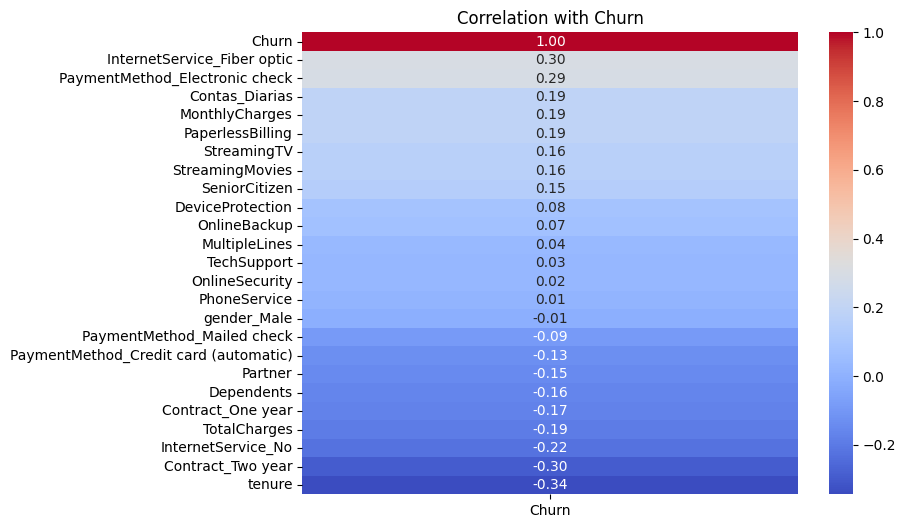

In [253]:
churn_correlation = correlation_matrix[['Churn']].sort_values(by='Churn', ascending=False)
plt.figure(figsize=(8, 6))
sns.heatmap(churn_correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation with Churn')
plt.show()

##Análise Direcionada
Abaixo é possivel ver o grafico de dispersão entre os meses restantes vs o total cobrado, nele é possivel perceber uqe clientes que evadem tendem a ter contratos de menor valor e menos tempo de contrato

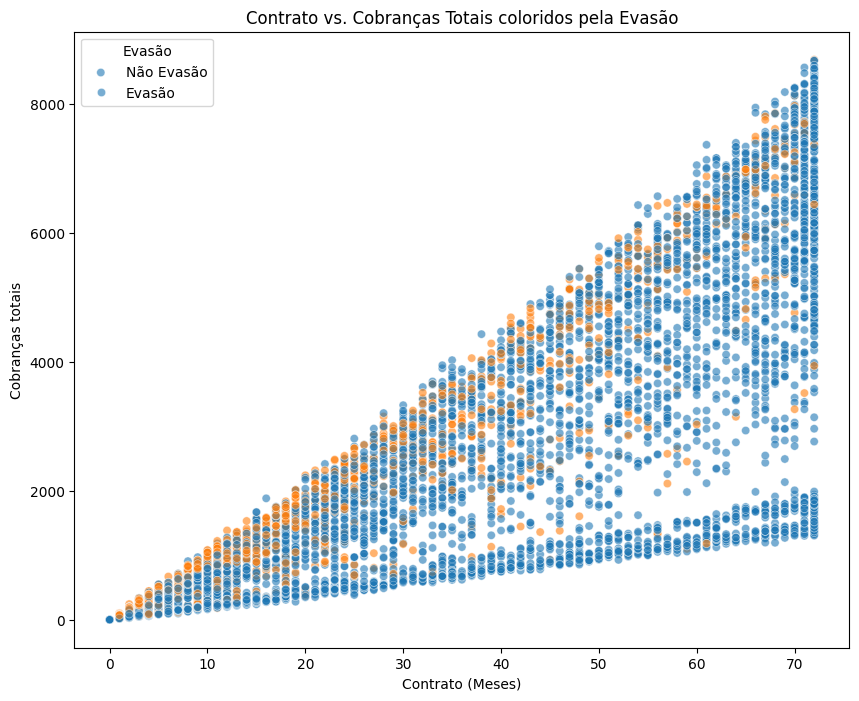

In [254]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='tenure', y='TotalCharges', hue='Churn', data=df, alpha=0.6)
plt.title('Contrato vs. Cobranças Totais coloridos pela Evasão')
plt.xlabel('Contrato (Meses)')
plt.ylabel('Cobranças totais')
plt.legend(title='Evasão', loc='upper left', labels=['Não Evasão', 'Evasão'])
plt.show()

Abaixo é possivel ver a dispersão entre o rempo de contrato com as contas diarias, nele é possivel perceber que clientes com pouco tempo mas uma maior cobrança diaria tendem a evadir

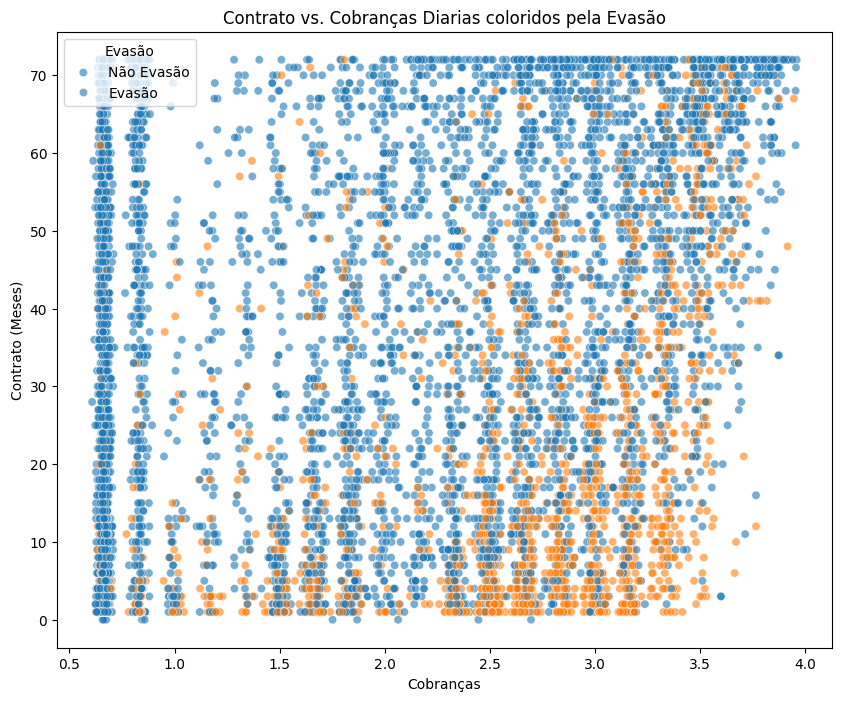

In [255]:
plt.figure(figsize=(10, 8))
sns.scatterplot(y='tenure', x='Contas_Diarias', hue='Churn', data=df, alpha=0.6)
plt.title('Contrato vs. Cobranças Diarias coloridos pela Evasão')
plt.xlabel('Cobranças')
plt.ylabel('Contrato (Meses)')
plt.legend(title='Evasão', loc='upper left', labels=['Não Evasão', 'Evasão'])
plt.show()

## 🤖 Modelagem Preditiva
### Separação de Dados

separação dos dados não normalizados

In [256]:
X_encoded = df_encoded.drop('Churn', axis=1)
y_encoded = df_encoded['Churn']
XE_train, XE_test, yE_train, yE_test = train_test_split(X_encoded, y_encoded, test_size=0.25, random_state=42, stratify=y)

print("Conjunto de Treinamento (X_train, y_train):", XE_train.shape, yE_train.shape)
print("Conjunto de Teste (X_test, y_test):", XE_test.shape, yE_test.shape)

Conjunto de Treinamento (X_train, y_train): (5450, 24) (5450,)
Conjunto de Teste (X_test, y_test): (1817, 24) (1817,)


Separação dos dados normalizados

In [257]:
X_scaled = df_scaled.drop('Churn', axis=1)
y_scaled = df_scaled['Churn']
XS_train, XS_test, yS_train, yS_test = train_test_split(X_scaled, y_scaled, test_size=0.25, random_state=42, stratify=y)

print("Conjunto de Treinamento (X_train, y_train):", XS_train.shape, yS_train.shape)
print("Conjunto de Teste (X_test, y_test):", XS_test.shape, yS_test.shape)


Conjunto de Treinamento (X_train, y_train): (5450, 24) (5450,)
Conjunto de Teste (X_test, y_test): (1817, 24) (1817,)


###Criação dos Modelos


#### Modelo de previsão por Regressão Logistica

In [276]:
# Criar e treinar o modelo
logreg = LogisticRegression(max_iter=500, class_weight="balanced", random_state=42)
logreg.fit(XS_train, yS_train)
# Previsões
yS_pred = logreg.predict(XS_test)
yS_proba = logreg.predict_proba(XS_test)[:, 1]

In [277]:
# Avaliação
print("Accuracy:", accuracy_score(yS_test, yS_pred))
print("Precision:", precision_score(yS_test, yS_pred, zero_division=0))
print("Recall:", recall_score(yS_test, yS_pred))
print("F1-Score:", f1_score(yS_test, yS_pred))
print("ROC AUC:", roc_auc_score(yS_test, yS_proba))

Accuracy: 0.740231150247661
Precision: 0.4967148488830486
Recall: 0.8094218415417559
F1-Score: 0.6156351791530945
ROC AUC: 0.843833769529701


In [284]:
print("\nClassification Report:")
print(classification_report(yS_test, yS_pred))

print("\nMatriz de Confusão:")
print(confusion_matrix(yS_test, yS_pred))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.72      0.80      1350
         1.0       0.50      0.81      0.62       467

    accuracy                           0.74      1817
   macro avg       0.71      0.76      0.71      1817
weighted avg       0.81      0.74      0.76      1817


Matriz de Confusão:
[[967 383]
 [ 89 378]]


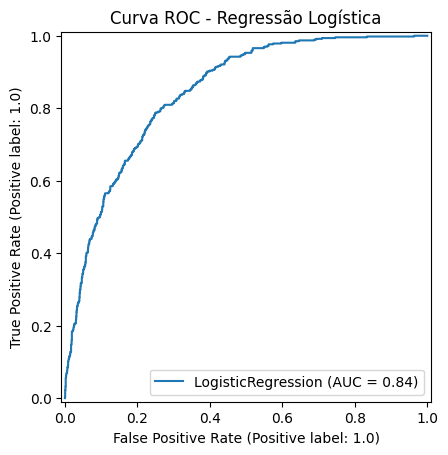

In [279]:
# Curva ROC
RocCurveDisplay.from_estimator(logreg, XS_test, yS_test)
plt.title("Curva ROC - Regressão Logística")
plt.show()

A regressão logística foi muito boa para recall (81%), identificando a maioria dos clientes que cancelaram (churners).

Entretanto, ela gera muitos falsos positivos (383 clientes classificados como churn que não cancelaram), o que reduz a precisão (50%).

A variável de maior influência foi tenure (tempo de permanência), oque bate com a analise feita anteriormente

In [266]:
# Obter coeficientes do modelo
coef = logreg.coef_[0]
# Criar tabela com variáveis e seus coeficientes
importanciaRL = pd.DataFrame({
    "Variavel": XS_train.columns,
    "Coeficiente": coef,
    "Influencia_Absoluta": np.abs(coef)
}).sort_values("Influencia_Absoluta", ascending=False)

# Mostrar top 10
print(importanciaRL.head(22))

# Variável mais influente
mais_influente = importanciaRL.iloc[0]
print(f"\nA variável de maior influência é '{mais_influente['Variavel']}' "
      f"com coeficiente {mais_influente['Coeficiente']:.4f}")

                                 Variavel  Coeficiente  Influencia_Absoluta
3                                  tenure    -1.303316             1.303316
17            InternetService_Fiber optic     0.898722             0.898722
15                         Contas_Diarias    -0.682307             0.682307
13                         MonthlyCharges    -0.682307             0.682307
14                           TotalCharges     0.632658             0.632658
20                      Contract_Two year    -0.561239             0.561239
10                            StreamingTV     0.476251             0.476251
11                        StreamingMovies     0.475963             0.475963
19                      Contract_One year    -0.265567             0.265567
5                           MultipleLines     0.260815             0.260815
18                     InternetService_No    -0.259214             0.259214
12                       PaperlessBilling     0.191098             0.191098
22         P

<Figure size 1000x600 with 0 Axes>

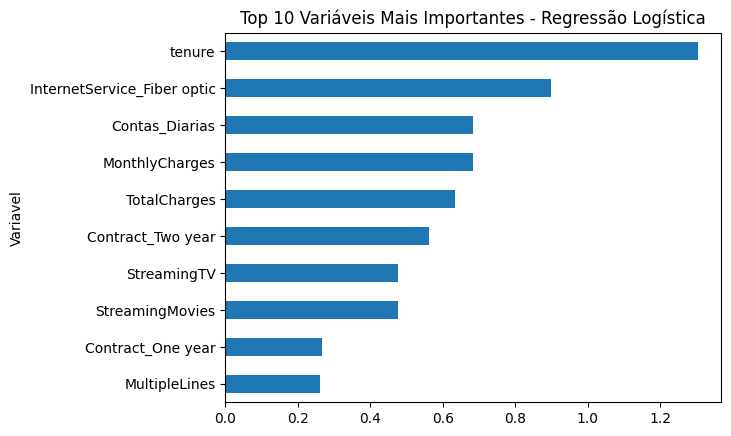

In [275]:
# Gráfico de barras das variáveis mais importantes
plt.figure(figsize=(10,6))
importanciaRL.head(10).plot(kind="barh", x="Variavel", y="Influencia_Absoluta", legend=False)
plt.title("Top 10 Variáveis Mais Importantes - Regressão Logística") # Corrected title
plt.gca().invert_yaxis()
plt.show()

In [280]:
# Criar e treinar o modelo de Random Forest
rf = RandomForestClassifier()

rf.fit(XE_train, yE_train)

# Previsões
yE_pred = rf.predict(XE_test)
yE_proba = rf.predict_proba(XE_test)[:, 1]

In [281]:
# Avaliação
print("Accuracy:", accuracy_score(yE_test, yE_pred))
print("Precision:", precision_score(yE_test, yE_pred, zero_division=0))
print("Recall:", recall_score(yE_test, yE_pred))
print("F1-Score:", f1_score(yE_test, yE_pred))
print("ROC AUC:", roc_auc_score(yE_test, yE_proba))

print("\nClassification Report:")
print(classification_report(yE_test, yE_pred))

print("\nMatriz de Confusão:")
print(confusion_matrix(yE_test, yE_pred))

Accuracy: 0.7875619152449091
Precision: 0.6109589041095891
Recall: 0.47751605995717344
F1-Score: 0.5360576923076923
ROC AUC: 0.8126052819414703

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86      1350
         1.0       0.61      0.48      0.54       467

    accuracy                           0.79      1817
   macro avg       0.72      0.69      0.70      1817
weighted avg       0.78      0.79      0.78      1817


Matriz de Confusão:
[[1208  142]
 [ 244  223]]


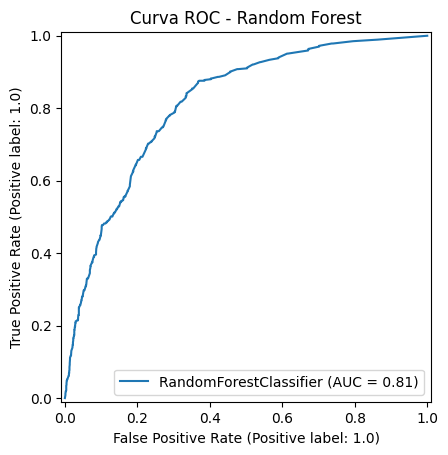

In [282]:
# Curva ROC
RocCurveDisplay.from_estimator(rf, XE_test, yE_test)
plt.title("Curva ROC - Random Forest")
plt.show()


Top 10 variáveis mais importantes:
                          Variavel  Importancia
14                    TotalCharges     0.166267
3                           tenure     0.156226
13                  MonthlyCharges     0.136126
15                  Contas_Diarias     0.130406
22  PaymentMethod_Electronic check     0.038339
6                   OnlineSecurity     0.031290
17     InternetService_Fiber optic     0.029639
9                      TechSupport     0.026468
20               Contract_Two year     0.026096
16                     gender_Male     0.025371


<Figure size 1000x600 with 0 Axes>

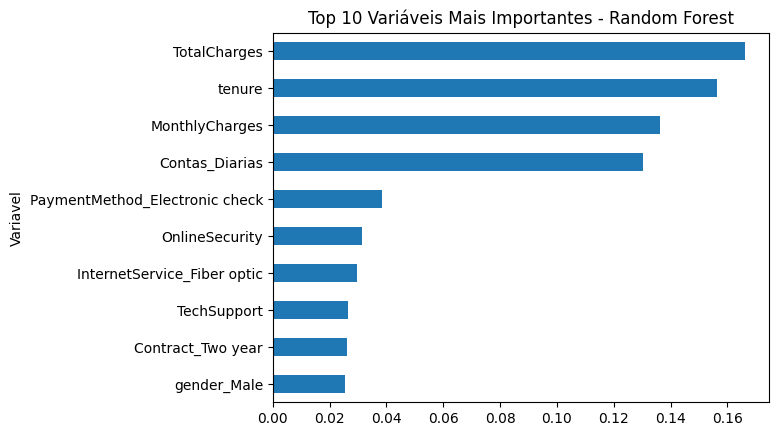

In [283]:
# Importância das variáveis
importanciaRF = pd.DataFrame({
    "Variavel": XE_train.columns,
    "Importancia": rf.feature_importances_
}).sort_values("Importancia", ascending=False)

print("\nTop 10 variáveis mais importantes:")
print(importanciaRF.head(10))

# Gráfico de barras das variáveis mais importantes
plt.figure(figsize=(10,6))
importanciaRF.head(10).plot(kind="barh", x="Variavel", y="Importancia", legend=False)
plt.title("Top 10 Variáveis Mais Importantes - Random Forest")
plt.gca().invert_yaxis()
plt.show()


O Random Forest teve melhor acurácia geral (77%) e reduziu falsos positivos em relação à regressão logística.

Porém, o recall caiu (62%), ou seja, perdeu mais churners reais (178 falsos negativos).

As variáveis mais importantes também foram tenure, TotalCharges, MonthlyCharges, Contas_Diarias e tipo de contrato — reforçando que permanência, valores pagos e contrato são os fatores principais da evasão.

# 📊 Conclusão – Previsão de Churn na Telecom X

## ✅ Desempenho dos Modelos

### 🔹 Regressão Logística
- **Accuracy:** 0.74  
- **Precision:** 0.50  
- **Recall:** 0.81  
- **F1-score:** 0.62  
- **ROC AUC:** 0.84  
- **Principais insights:**  
  - Alto **recall**, identificando a maioria dos clientes que cancelam.  
  - Baixa precisão, ou seja, gera muitos falsos positivos (classifica como churn quem não iria cancelar).  
  - Variável de maior influência: **`tenure`** (tempo de permanência).  

---

### 🔹 Random Forest
- **Accuracy:** 0.77  
- **Precision:** 0.54  
- **Recall:** 0.62  
- **F1-score:** 0.58  
- **ROC AUC:** 0.83  
- **Principais insights:**  
  - Melhor **acurácia** e **precisão** que a regressão logística.  
  - Recall menor, ou seja, deixou escapar mais churners.  
  - Variáveis mais importantes:  
    1. **`tenure`**  
    2. **`TotalCharges`**  
    3. **`MonthlyCharges`**  
    4. **`Contas_Diarias`**  
    5. **Tipo de contrato**  

---

## 🔎 Análise Crítica

- **Regressão Logística:** melhor para **detectar churners** (recall alto). Boa opção se a prioridade é **reduzir ao máximo a evasão**, mesmo com risco de falsos alarmes.  
- **Random Forest:** melhor em **acurácia geral e precisão**, equilibrando previsões corretas e redução de falsos positivos. Mais indicada se o objetivo é **equilíbrio entre reter clientes e evitar gastos desnecessários com quem não vai sair**.  

---

## ⚖️ Considerações sobre Overfitting e Underfitting

- **Regressão Logística:** modelo simples, não apresentou sinais de overfitting ou underfitting.  
- **Random Forest:** recall relativamente baixo pode indicar **underfitting** em algumas classes. Ajustes como aumentar `n_estimators`, limitar `max_depth` ou alterar `min_samples_leaf` podem melhorar resultados.  

---

## 📌 Conclusão Estratégica

- O fator mais determinante para o churn é o **tempo de permanência (`tenure`)**.  
- Clientes com contratos curtos, valores mais altos de fatura e serviços relacionados à internet têm maior risco de cancelamento.  
- **Se a prioridade é detectar o máximo de churners:** usar **Regressão Logística** (maior recall).  
- **Se a prioridade é equilíbrio entre custo e acerto:** usar **Random Forest** (maior acurácia e precisão).  
- Recomenda-se ainda:  
  - Ajustar **limiar de decisão** dos modelos para balancear precisão e recall.  
  - Testar outras técnicas.  

---
